In [1]:
import os
import math
import cv2
import glob
import zipfile
import scipy
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
from urllib.request import urlretrieve
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

%matplotlib inline


In [2]:
def get_output_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    return output_dir

def get_classifier_path():
    return './classifier.pickle'

def save_plt_img(fig_handle, fname):
    plt.figure(fig_handle.number)
    plt.savefig(os.path.join(get_output_dir(), fname + '.jpg'))
    
def save_cv_img(img, fname):
    scipy.misc.imsave(os.path.join(get_output_dir(), fname + '.jpg'), img)
    
def read_img(fname):
    return scipy.misc.imread(fname)

def display_img(img, title):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    
    plt.axis('off')
    plt.title(title)
    
def use_debug():
    return True


In [3]:
vehicles_file = 'vehicles.zip'
non_vehicles_file = 'non-vehicles.zip'
download_url_base = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/'

In [4]:
def download(url):
    # Get file name
    file = url.rsplit('/', 1)[-1]
    
    # Download
    print('Downloading ' + file + '...')
    if not os.path.isfile(file):
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File already in the filesystem!')
        
download(url = download_url_base + vehicles_file)
download(url = download_url_base + non_vehicles_file)

File already in the filesystem!
File already in the filesystem!


In [5]:
def unzip(file):
    if not os.path.isdir(os.path.splitext(file)[0]):        
        print('Unzipping ' + file + '...')
        with zipfile.ZipFile(file,"r") as zip_ref:
            zip_ref.extractall()
    else:
        print('File ' + file + ' already unpacked!')

unzip(vehicles_file)
unzip(non_vehicles_file)


Unzipping vehicles.zip...
Unzipping non-vehicles.zip...


In [6]:
def get_img_shape():
    return (64, 64, 3)

def get_vehicle_label():
    return 1

def get_non_vehicle_label():
    return 0

def load_dataset(class_base_folder, class_id):
    # Get filenames recursively
    f_names = glob.glob(class_base_folder + '/**/*.png')
    
    # Declare output arrays
    n_img = len(f_names)
    X = np.zeros((n_img,) + get_img_shape(), dtype = np.uint8)
    y = np.zeros((n_img,), dtype = int)
    
    # Read images and store them in memory
    for i in range(n_img):
        # Note: the input image is PNG, therefore a float32 array between 0.0 and 1.0
        X[i] = read_img(f_names[i])
        y[i] = class_id
        
    return X, y

print('Loading datasets...')
Img_v, y_v = load_dataset('vehicles', get_vehicle_label())
Img_nv, y_nv = load_dataset('non-vehicles', get_non_vehicle_label())
print('Done...')


Loading datasets...
Done...


In [7]:
print('Vehicle training data: ', Img_v.shape, y_v.shape)
print('Non-vehicle training data: ', Img_nv.shape, y_nv.shape)

Img = np.concatenate((Img_v, Img_nv))
y = np.concatenate((y_v, y_nv))

print('Combined dataset: ', Img.shape, y.shape)
print(np.amin(Img), np.amax(Img))

Vehicle training data:  (8792, 64, 64, 3) (8792,)
Non-vehicle training data:  (8968, 64, 64, 3) (8968,)
Combined dataset:  (17760, 64, 64, 3) (17760,)
0 255


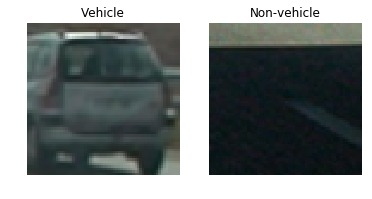

In [8]:
h = plt.figure()
plt.subplot(1,2,1);
display_img(Img_v[0], 'Vehicle')
plt.subplot(1,2,2);
display_img(Img_nv[0], 'Non-vehicle')

save_plt_img(fig_handle=h, fname='vehicle_non_vehicle')

In [9]:
def random_translation(img):
    rows = img.shape[0]
    cols = img.shape[1]
    
    delta_x_max = cols//2
    delta_y_max = rows//2
    
    tr_x = np.random.uniform(-delta_x_max, delta_x_max)
    tr_y = np.random.uniform(-delta_y_max, delta_y_max)

    M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    img_out = cv2.warpAffine(img,M,(cols,rows))
    
    return img_out

def augment_image(img):
    return random_translation(img)
    
def augment_data(Img, y):
    augmentation_factor = 2
    
    Img_extra = []
    y_extra = []
    
    for i in range(len(y)):
        for j in range(augmentation_factor):
            Img_extra.append(augment_image(Img[i]))
            y_extra.append(y[i])
    
    Img_extra = np.array(Img_extra)
    y_extra = np.array(y_extra)
    
    Img = np.concatenate((Img, Img_extra))
    y = np.concatenate((y, y_extra))
    
    return Img, y

print('Before data augmentation: ', Img.shape, y.shape)
#Img, y = augment_data(Img, y)
print('After data augmentation: ', Img.shape, y.shape)

Before data augmentation:  (17760, 64, 64, 3) (17760,)
After data augmentation:  (17760, 64, 64, 3) (17760,)


In [10]:
def rgb_to_ycrcb(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def preprocess_img(Img):
    Img_out = np.copy(Img)
    
    if len(Img.shape) == 3:
        Img_out = rgb_to_ycrcb(Img)
    else:
        for i in range(Img.shape[0]):
            Img_out[i] = cv2.cvtColor(Img[i], cv2.COLOR_RGB2YCrCb)
    
    return Img_out

Img_v_pp = preprocess_img(Img_v)
Img_nv_pp = preprocess_img(Img_nv)
Img_pp = preprocess_img(Img)

In [11]:
def get_pixels_per_cell():
    return 8

def get_hog_features(img, debug = False):
    # Setup HOG parameters
    pix_per_cell = get_pixels_per_cell()
    cell_per_block = 2
    orient = 9

    img_shape = img.shape
    n_channels = img_shape[2]
    
    features = []
    hog_image = np.zeros_like(img)
    
    for i in range(n_channels):
        if debug:
            features_i, hog_image[:, :, i] = hog(img[:, :, i], orientations=orient, 
                                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                                 cells_per_block=(cell_per_block, cell_per_block),
                                                 visualise=debug, feature_vector=False)
        else:
            features_i = hog(img[:, :, i], orientations=orient, 
                             pixels_per_cell=(pix_per_cell, pix_per_cell),
                             cells_per_block=(cell_per_block, cell_per_block),
                             visualise=debug, feature_vector=False)
       
        features.append(features_i)

    features = np.stack(features, axis=-1)
        
    if debug:        
        return features, hog_image
    else:
        return features

(7, 7, 2, 2, 9, 3) float64 (64, 64, 3) uint8


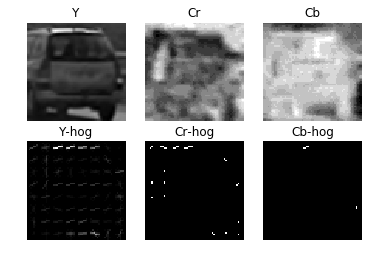

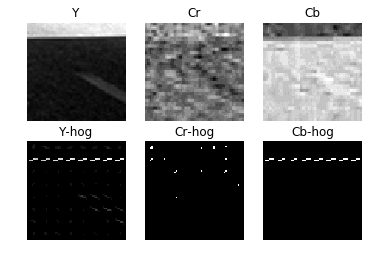

In [12]:
def test_hog_features():
    img_v = Img_v_pp[0]
    img_nv = Img_nv_pp[0]

    features_v, hog_image_v = get_hog_features(img_v, debug=True)
    features_nv, hog_image_nv = get_hog_features(img_nv, debug=True)

    print(features_v.shape, features_v.dtype, hog_image_v.shape, hog_image_v.dtype)

    h = plt.figure()
    img_labels = ['Y', 'Cr', 'Cb']

    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 0 + 1);
        display_img(img_v[:, :, idx], img_labels[idx])

    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 1 + 1);
        display_img(hog_image_v[:, :, idx], img_labels[idx] + '-hog')
        
    save_plt_img(fig_handle=h, fname='hog_img_vehicle')
        
    h = plt.figure()
    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 0 + 1);
        display_img(img_nv[:, :, idx], img_labels[idx])
        
    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 1 + 1);
        display_img(hog_image_nv[:, :, idx], img_labels[idx] + '-hog')
        
    save_plt_img(fig_handle=h, fname='hog_img_non_vehicle')        

test_hog_features()

In [13]:
class SearchWindow:
    
    def __init__(self, x0, y0, size_x, size_y):
        self.x0 = x0
        self.y0 = y0
        self.size_x = size_x
        self.size_y = size_y  
        
    def get_img_contents(self, img):
        return img[self.y0 : self.y0 + self.size_y, 
                   self.x0 : self.x0 + self.size_x]
    
    def resize(self, scale):
        self.x0 = int(self.x0 / scale)
        self.y0 = int(self.y0 / scale)
        self.size_x = int(self.size_x / scale)
        self.size_y = int(self.size_y / scale)
    
    def draw_on_img(self, img, color=(0,0,255), thickness=2):
        p1 = (self.x0,               self.y0)
        p2 = (self.x0,               self.y0 + self.size_y)
        p3 = (self.x0 + self.size_x, self.y0 + self.size_y)
        p4 = (self.x0 + self.size_x, self.y0)
        
        p = (p1, p2, p3, p4)
        
        for i in range(4):
            cv2.line(img, p[i], p[(i+1) % 4], color=color, thickness=thickness)

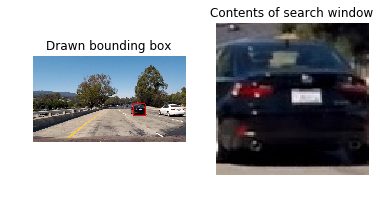

In [14]:
def test_get_img_contents():
    img = read_img('./test_images/test1.jpg')
    window = SearchWindow(840,400,100,100)
    display_img(window.get_img_contents(img), 'Contents of search window')
    
def test_draw_on_img():
    img = read_img('./test_images/test1.jpg')
    window = SearchWindow(840,400,100,100)    
    window.draw_on_img(img, color = (255,0,0), thickness=5)
    display_img(img, 'Drawn bounding box')

plt.figure();
plt.subplot(1,2,1)
test_draw_on_img()    
plt.subplot(1,2,2)
test_get_img_contents()


In [15]:
def get_hog_features_on_window(hog_features_from_global_img, window, pixels_per_cell):
    '''
        Extracts HOG features given as input the HOG features
        from the complete image. This way we only need to compute
        them once.
    '''
    # Get block indices for this bounding box
    block_idx_x_start = window.x0 // pixels_per_cell 
    block_idx_y_start = window.y0 // pixels_per_cell

    block_idx_x_end = block_idx_x_start + window.size_x // pixels_per_cell - 1
    block_idx_y_end = block_idx_y_start + window.size_y // pixels_per_cell - 1

    # Extract features
    return hog_features_from_global_img[block_idx_y_start : block_idx_y_end,
                                        block_idx_x_start : block_idx_x_end]

(89, 159, 2, 2, 9, 3)
(7, 7, 2, 2, 9, 3)
(7, 7, 2, 2, 9, 3)
Test passed!


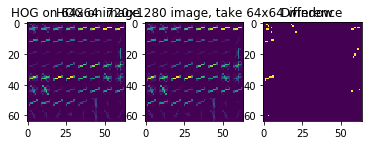

In [16]:
def test_hog_features_window():
    # Read image
    img = preprocess_img(read_img('./test_images/test1.jpg'))
    img2 = np.copy(img)
    
    # Define window
    x0 = 192
    y0 = 448
    pixels_per_cell = get_pixels_per_cell()
    window = SearchWindow(x0, y0, 64, 64)
    
    # Get sub-image and compute HOG features
    sub_img = window.get_img_contents(img)
    features_sub_image, debug1 = get_hog_features(sub_img, debug=True)
    
    # Compute HOG features in global image, and get features from it
    hog_features_whole_image, debug2 = get_hog_features(img2, debug=True)
    print(hog_features_whole_image.shape)
    features_sub_hog = get_hog_features_on_window(hog_features_whole_image, window, pixels_per_cell=pixels_per_cell)
    
    # Verify that the vector is exactly the same
    print(features_sub_image.shape)
    print(features_sub_hog.shape)
    
    plt.figure()
    plt.subplot(1,3,1)
    plt.title('HOG on 64x64 image')    
    plt.imshow(debug1[:, :, 0])
    plt.subplot(1,3,2)
    plt.title('HOG on 720x1280 image, take 64x64 window')
    plt.imshow(debug2[y0:y0+64,x0:x0+64, 0])
        
    plt.subplot(1,3,3)
    plt.imshow(debug1[:,:,0] - debug2[y0:y0+64,x0:x0+64, 0])
    plt.title('Difference')
        
    assert(features_sub_image.shape == features_sub_hog.shape)
   
    n_blocks = 64 // pixels_per_cell - 1

    for i in range(1, n_blocks - 1):
        assert(np.sum(abs(features_sub_image[i, 1]          - features_sub_hog[i, 1])) == 0.)
        assert(np.sum(abs(features_sub_image[i, n_blocks-2] - features_sub_hog[i, n_blocks-2])) == 0.)
        assert(np.sum(abs(features_sub_image[1, i]          - features_sub_hog[1, i])) == 0.)
        assert(np.sum(abs(features_sub_image[n_blocks-2, i] - features_sub_hog[n_blocks-2, i])) == 0.)
    
    print('Test passed!')
    
test_hog_features_window()

In [18]:
def color_hist_features(img):
    nbins = 32
    bins_range = (0, 256)
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [19]:
def bin_spatial(img):
    size = (16, 16)
    return cv2.resize(img, size).ravel()

In [20]:
def combine_features(bin_spatial_feat, color_hist_feat, hog_feat):
    features = []
    
    features.append(bin_spatial_feat)
    features.append(color_hist_feat)
    features.append(hog_feat.ravel())
    
    return np.array(np.concatenate(features))
    
def get_features(img):
    bin_spatial_feat = bin_spatial(img)
    color_hist_feat = color_hist_features(img)
    hog_feat = get_hog_features(img)
    
    return combine_features(bin_spatial_feat, color_hist_feat, hog_feat)
    
def get_features_batch(Img):
    features = []
    for i in range(Img.shape[0]):
        features.append(get_features(Img[i]))
    return np.array(features)

In [21]:
features_file = 'features.pickle'

if not os.path.exists(features_file):
    print('Computing features for the entire dataset...')
    X = get_features_batch(Img_pp)
    print('Saving features into ' + features_file + '...')
    pickle.dump(X, open(features_file, 'wb'))
    print('Done')
else:
    print('Loading features from ' + features_file + '...')
    X = pickle.load(open(features_file, 'rb'))
    print('Done')
    
X = X.astype(np.float64)
print(X.shape)


Computing features for the entire dataset...
Saving features into features.pickle...
Done
(17760, 6156)


In [22]:
def create_scaler(X):
    scaler = StandardScaler().fit(X)
    return scaler

scaler_ = create_scaler(X)

In [23]:
def normalize_features(X):
    return scaler_.transform(X)    

print('Normalizing features...')
X_norm = normalize_features(X)
print('Done')


Normalizing features...
Done


In [24]:
def split_validation(X, y):
    val_ratio = 0.2
    random_state = 918273645
    return train_test_split(X, y, test_size = val_ratio, random_state = random_state)

print('Splitting into train/validation set...')
X_train, X_val, y_train, y_val = split_validation(X_norm, y)

print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)

Splitting into train/validation set...
X_train:  (14208, 6156)
X_val:  (3552, 6156)


In [25]:
def define_classifier():
    kernel='rbf'
    #classifier = SVC(kernel=kernel)
    classifier = LinearSVC(C = 0.001) 
    return classifier

In [26]:
def train_classifier(classifier, X_train, y_train):
    classifier.fit(X_train, y_train)
def save_classifier(classifier, path):
    joblib.dump(classifier, path)
def load_classifier(path):
    return joblib.load(path)
if not os.path.exists(get_classifier_path()):
    # Create classifier
    classifier_ = define_classifier()
    
    # Train it
    print('Training classifier...')
    t = time.time()
    train_classifier(classifier_, X_train, y_train)
    print('Done in %.3f s' % (time.time() - t))
    
    # Save to disk for the future
    save_classifier(classifier_, get_classifier_path())
else:
    print('Loading classifier...')
    classifier_ = load_classifier(get_classifier_path())
    print('Done')

Training classifier...
Done in 18.091 s


In [27]:
def compute_validation_accuracy(classifier, X_val, y_val):
    return classifier.score(X_val, y_val)
    
print('Validation accuracy: %.3f%%' % (100. * compute_validation_accuracy(classifier_, X_val, y_val)))

Validation accuracy: 99.437%


In [28]:
def predict(x):
    v = classifier_.decision_function(x)
    v_threshold = 0.1
    
    if v > v_threshold:
        return get_vehicle_label()
    else:
        return get_non_vehicle_label()

In [29]:
def classify_img(img):
    # Preprocess
    img = preprocess_img(img)
    
    # Extract and normalize features
    x = get_features(img)
    x = normalize_features(x)
    
    # Predict
    return predict(x)

In [30]:
img_v_test = Img_v[0]
t = time.time()
y_v_predicted = classify_img(img_v_test)
print('Time for classifying single 64x64 image: %.3f s' % (time.time() - t))

img_nv_test = Img_nv[0]
y_nv_predicted = classify_img(img_nv_test)

h = plt.figure();
plt.subplot(1,2,1);
display_img(img_v_test, 'Prediction: %d (True: %d)' % (y_v_predicted, get_vehicle_label()))
plt.subplot(1,2,2);
display_img(img_nv_test, 'Prediction: %d (True: %d)' % (y_nv_predicted, get_non_vehicle_label()))

save_plt_img(h, 'svm_test')

ValueError: Expected 2D array, got 1D array instead:
array=[7.90000000e+01 1.28000000e+02 1.26000000e+02 ... 3.19036265e-03
 4.14879384e-02 2.93629386e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
def get_search_windows(img_shape):
    # Parameters
    x_start = 0
    y_start = img_shape[0] // 2
    x_end = img_shape[1]
    y_end = img_shape[0]
    
    size = 64
    overlap = 0.75    

    # Search windows
    bboxes_out = []
    step = int((1.0 - overlap) * size) 

    for y in range(y_start, y_end - size, step):
        for x in range(x_start, x_end - size, step):                
            box = SearchWindow(x, y, size, size)
            bboxes_out.append(box)
        
    return bboxes_out

In [ ]:
def draw_search_windows(img, windows, color, thickness):
    for w in windows:
        w.draw_on_img(img, color, thickness)

In [ ]:
def test_bboxes():
    img = read_img('./test_images/test1.jpg')
    bboxes = get_search_windows(img.shape)
    print('Obtained %d boxes' % len(bboxes))
    draw_search_windows(img, bboxes, color=(255,0,0), thickness=2)
    plt.imshow(img)
    save_cv_img(fname= 'search_boxes', img=img)
    
test_bboxes()